# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

Максимальный балл за задание 10 баллов

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn). Каждый пункт задания весит 1 балл, если вы не ответили на какой-то вопрос, снимается 1/10 балла.

A . Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
 # это все я добавила
import numpy as np
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures


In [17]:
df = pd.read_csv('/Users/kh11vika/Downloads/telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Подготовка данных

In [18]:
#меняем категориальные признаки
df['International plan'] = df['International plan'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Voice mail plan'] = df['Voice mail plan'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x else 0)

#выбираем признаки и целевую переменную
X = df.drop(['State', 'Churn'], axis=1)
y = df['Churn']

#стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)

### A. Логистическая регрессия

In [19]:
import warnings
#отключаю предупреждения, так как код вызывает их из-за того, что lbfgs поддерживает только регуляризацию l2/отсутствие регуляризации
warnings.filterwarnings('ignore')

In [20]:
log_reg = LogisticRegression()

grid = {
    'C': [0.01, 0.1, 1, 10, 100],     #гиперпараметр регуляризации
    'penalty': ['l2', 'l1'] ,         
    'solver': ['lbfgs', 'liblinear']  #ChatGPT предложил попробовать эти методы оптимизации
}

grid_search = GridSearchCV(log_reg, grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print("Лучшие параметры логистической регрессии:", grid_search.best_params_)
print("\nA. Логистическая регрессия:\n", classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc:.4f}")


Лучшие параметры логистической регрессии: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

A. Логистическая регрессия:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       561
           1       0.64      0.20      0.30       106

    accuracy                           0.85       667
   macro avg       0.75      0.59      0.61       667
weighted avg       0.83      0.85      0.82       667

ROC AUC: 0.5884


Получается, что у нас высокая точность и полноту для класса 0 и ниже для класса 1 => модель явно недообучена для класса 1.  По-хорошему нужна обработка дисбаланса классов или изменения порога классификации.
Я бы сказала, что качество модели неудовлетворительное. Модель не справилась со своей основной целью (правильно идентифицировать клиентов, которые могут уйти) и это грустно(

### В. Метод опорных векторов

In [21]:
svm = SVC(kernel='linear', class_weight='balanced') #без class_weight='balanced' класс 1 полностью игнорировался (помог ChatGPT это исправить)

grid = {'C': [0.01, 0.1, 1, 10]}

grid_search_svm = GridSearchCV(svm, grid, cv=3, scoring='accuracy', n_jobs=-1) #пробую scoring='accuracy'
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_svm)

print("Лучшие параметры SVM:", grid_search_svm.best_params_)
print("\nВ. Метод опорных векторов:\n", classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc:.4f}")

Лучшие параметры SVM: {'C': 10}

В. Метод опорных векторов:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81       561
           1       0.35      0.82      0.49       106

    accuracy                           0.73       667
   macro avg       0.65      0.76      0.65       667
weighted avg       0.86      0.73      0.76       667

ROC AUC: 0.7642


Мой исходный код был супер медленным, поэтому я ~попросила ChatGPT~ решила оптимизировать его. Mы с моим верным другом убрали 100 в значении С, уменьшили количество фолдов до 3 и добавили n_jobs=-1 (использование всех доступных ядер процессора для параллельного выполнения GridSearch). Код выводится сейчас намного быстрее, но с warning (oни были отключены еще в предыдущем пункте).

Получается, что модель показывает высокие значения точности и полноты для класса 0, но уступает по этим метрикам для класса 1. Это указывает на то, что модель недообучена для класса 1 (same as previous) 

### C 

In [22]:
#создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, interaction_only=True)  
X_poly = poly.fit_transform(X_scaled)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=16)

# A. Логистическая регрессия с полиномиальными признаками
log_reg_poly = LogisticRegression()
log_reg_poly.fit(X_train_poly, y_train)
y_pred_poly = log_reg_poly.predict(X_test_poly)
roc_auc_a = roc_auc_score(y_test, y_pred_poly)

print("\nA. Логистическая регрессия с полиномиальными признаками:\n", classification_report(y_test, y_pred_poly))
print(f"ROC AUC: {roc_auc_a:.4f}")

# В. Метод опорных векторов с полиномиальными признаками
svm_poly = SVC(kernel='linear')
svm_poly.fit(X_train_poly, y_train)
y_pred_svm_poly = svm_poly.predict(X_test_poly)
roc_auc_b = roc_auc_score(y_test, y_pred_svm_poly)

print("\nB. Метод опорных векторов с полиномиальными признаками:\n", classification_report(y_test, y_pred_svm_poly))
print(f"ROC AUC: {roc_auc_b:.4f}")


A. Логистическая регрессия с полиномиальными признаками:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       561
           1       0.81      0.55      0.65       106

    accuracy                           0.91       667
   macro avg       0.86      0.76      0.80       667
weighted avg       0.90      0.91      0.90       667

ROC AUC: 0.7611

B. Метод опорных векторов с полиномиальными признаками:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       561
           1       0.80      0.52      0.63       106

    accuracy                           0.90       667
   macro avg       0.86      0.75      0.79       667
weighted avg       0.90      0.90      0.89       667

ROC AUC: 0.7470


Добавление полиномиальных признаков улучшило точность для класса 1 (и для логистической регрессии, и для метода опорных векторов), но модель все еще не справляется с идентификацией всех объектов класса 1 (полнота остаётся низкой, но не сильно).

Качество модели значительно улучшилось по сравнению с первоначальной версией, но до идеала ещё далеко (как и мне до окончания вышки, а я уже устала()

### D

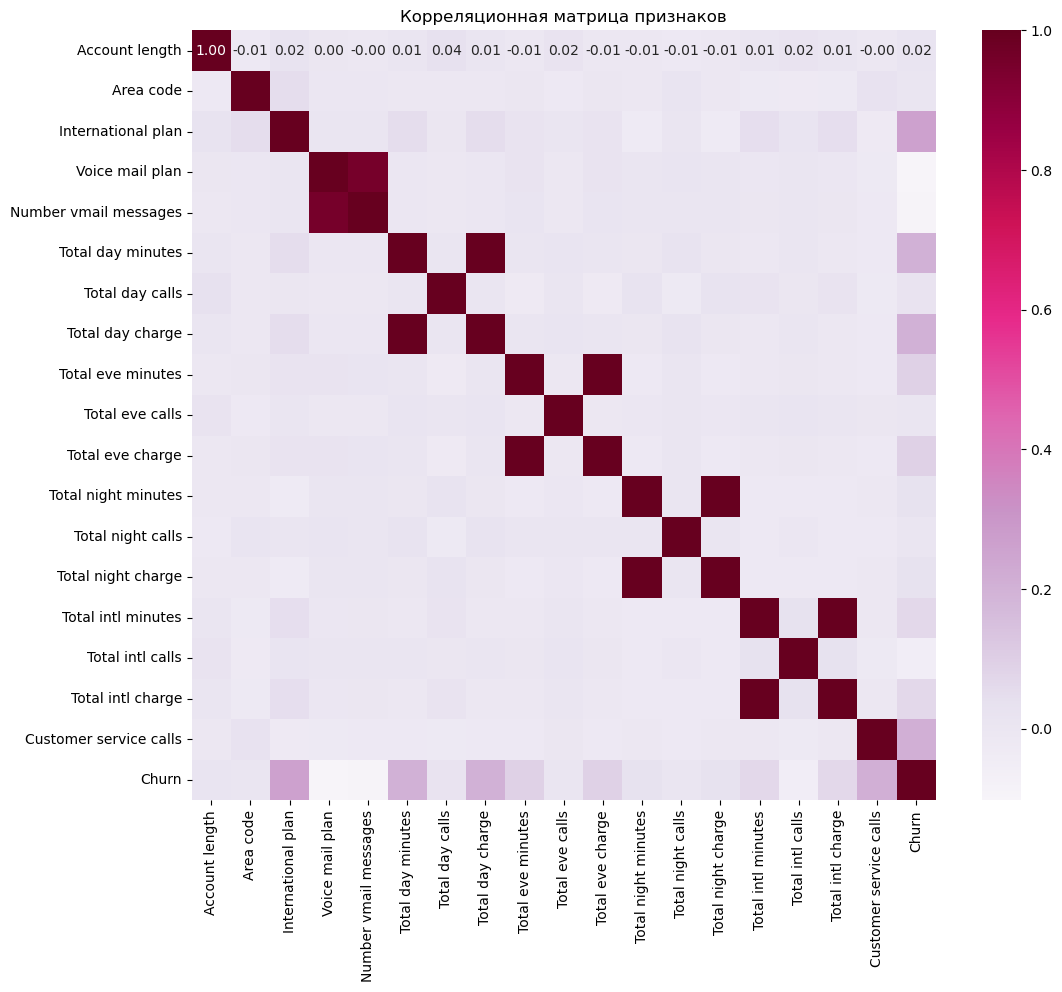

А. Логистическая регрессия с удаленными признаками:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       561
           1       0.65      0.23      0.34       106

    accuracy                           0.86       667
   macro avg       0.76      0.60      0.63       667
weighted avg       0.83      0.86      0.83       667

ROC AUC: 0.7611
В. Метод опорных векторов на модифицированном наборе данных:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       561
           1       0.00      0.00      0.00       106

    accuracy                           0.84       667
   macro avg       0.42      0.50      0.46       667
weighted avg       0.71      0.84      0.77       667

ROC AUC: 0.5000


In [23]:
#убираем категориальные признаки, такие как 'State'
df_numeric = df.drop(columns=['State'])

#строим корреляционную матрицу
plt.figure(figsize=(12, 10))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.PuRd, fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

#находим признаки, которые слабо коррелируют с целевой переменной 'Churn'
weak_corr_features = correlation_matrix['Churn'][abs(correlation_matrix['Churn']) < 0.05].index.tolist()

#находим пары признаков с высокой корреляцией 
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j))

#удаляем признаки с низкой корреляцией с целевой переменной
df_reduced = df_numeric.drop(columns=weak_corr_features)

#удаляем по одному признаку из каждой пары высококоррелирующих признаков
for (col1, col2) in high_corr_pairs:
    if col1 in df_reduced.columns and col2 in df_reduced.columns:
        df_reduced = df_reduced.drop(columns=[col2])

X = df_reduced.drop(columns=['Churn'])  
y = df_reduced['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# А. Логистическая регрессия на модифицированном наборе данных
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
roc_auc_b = roc_auc_score(y_test, y_pred_log_reg)

print("А. Логистическая регрессия с удаленными признаками:\n", classification_report(y_test, y_pred_log_reg))
print(f"ROC AUC: {roc_auc_a:.4f}")

# В. Метод опорных векторов на модифицированном наборе данных
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
roc_auc_b = roc_auc_score(y_test, y_pred_svm)

print("В. Метод опорных векторов на модифицированном наборе данных:\n", classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc_b:.4f}")

Удаление признаков, даже если они не коррелируют с целевой переменной или сильно коррелируют между собой, в данной задаче не улучшило качество модели. Напротив, результаты ухудшились, возможно, из-за того, что удаленные признаки содержали информацию, полезную для классификации. Короче грустинка(

### Мини-отчет о проделанной работе

#### a) Какой классификатор дал наилучший результат? Чему равны значения метрик accuracy, f1-score и ROC-AUC?

Самый хороший результат был получен с использованием **метода опорных векторов (SVM)** с полиномиальными признаками. 
- **Accuracy**: 0.90
- **F1-score** (класс 1): 0.63
- **ROC-AUC**: 0.7470

Логистическая регрессия с полиномиальными признаками показала результаты чуть-чуть похуже:

- **Accuracy**: 0.91
- **F1-score** (класс 1): 0.65
- **ROC-AUC**: 0.7611

Логистическая регрессия с полиномиальными признаками имела получше показатель ROC-AUC и F1-score для класса 1, но в целом оба алгоритма близко друг к другу по результатам.

#### b) Какие новые признаки вы добавили и какие признаки удалили?

- Точно  добавила бы **полиномиальные признаки**. Они прямо точно помогли улучшить качество модели, особенно для класса 1.

#### c) Удалось ли добиться того, что алгоритм не переобучился и не недообучился?

- Для **логистической регрессии** модель, несмотря на улучшение качества после добавления полиномиальных признаков, все равно продолжает показывать хорошую точность для класса 0, но слабо справляется с классом 1. Это указывает на **недообученность** модели для класса 1 (метрики **recall** и **f1-score** +уют под этим утдверждением).
  
- Для **метода опорных векторов** (SVM) с полиномиальными признаками модель также неидеально справляется с классом 1. Переобучения вроде как нет, но для класса 1 есть значительные проблемы с точностью и полнотой.

## Часть 2. Оценка качества моделей классификации (5 баллов).

В этой части вы будете работать с данными в задаче скоринга. За работу с этими данными можно получить **5 баллов.**

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [24]:
df = pd.read_csv("/Users/kh11vika/Downloads/credit_scoring_example.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


**Задание 1. (0.25  баллов)** Проверьте target на сбалансированность по классам, сделайте вывод.

In [25]:
class_distribution = df['target'].value_counts(normalize=True)
print(class_distribution)

target
0    0.554427
1    0.445573
Name: proportion, dtype: float64


Классы можно считать относительно сбалансированными, так как разница между ними составляет около 9-10% 

**Задание 2. (0.25  баллов)** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [26]:
#accuracy для каждого алгоритма
accuracy_alg1 = (df['pred1_classes'] == df['target']).mean()
accuracy_alg2 = (df['pred2_classes'] == df['target']).mean()
accuracy_alg3 = (df['pred3_classes'] == df['target']).mean()

print(f"Accuracy алгоритм 1: {accuracy_alg1:.4f}")
print(f"Accuracy алгоритм 2: {accuracy_alg2:.4f}")
print(f"Accuracy алгоритм 3: {accuracy_alg3:.4f}")

max_accuracy = max(accuracy_alg1, accuracy_alg2, accuracy_alg3)
best_algorithm = {1: accuracy_alg1, 2: accuracy_alg2, 3: accuracy_alg3}
best_algorithm_num = max(best_algorithm, key=best_algorithm.get)

print(f"В номинации ЛУЧШИЙ АЛГОРИТМ победил алгоритм под номером {best_algorithm_num}")


Accuracy алгоритм 1: 0.6618
Accuracy алгоритм 2: 0.6720
Accuracy алгоритм 3: 0.6401
В номинации ЛУЧШИЙ АЛГОРИТМ победил алгоритм под номером 2


**Задание 3. (0.25  баллов)** Теперь вычислите точность и полноту каждого из алгоритмов.

In [31]:
y_true = df['target']

#для алгоритма 1
precision_1 = precision_score(y_true, df['pred1_classes'])
recall_1 = recall_score(y_true, df['pred1_classes'])

#для алгоритма 2
precision_2 = precision_score(y_true, df['pred2_classes'])
recall_2 = recall_score(y_true, df['pred2_classes'])

#для алгоритма 3
precision_3 = precision_score(y_true, df['pred3_classes'])
recall_3 = recall_score(y_true, df['pred3_classes'])

print(f'Алгоритм 1: точность = {precision_1:.4f}, полнотa = {recall_1:.4f}')
print(f'Алгоритм 2: точность = {precision_2:.4f}, полнотa = {recall_2:.4f}')
print(f'Алгоритм 3: точность = {precision_3:.4f}, полнотa = {recall_3:.4f}')

Алгоритм 1: точность = 0.6907, полнотa = 0.4365
Алгоритм 2: точность = 0.6104, полнотa = 0.7296
Алгоритм 3: точность = 0.6903, полнотa = 0.3485


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4. (0.25  баллов)** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd): #я поменяла цвет, хочу все розовое!
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

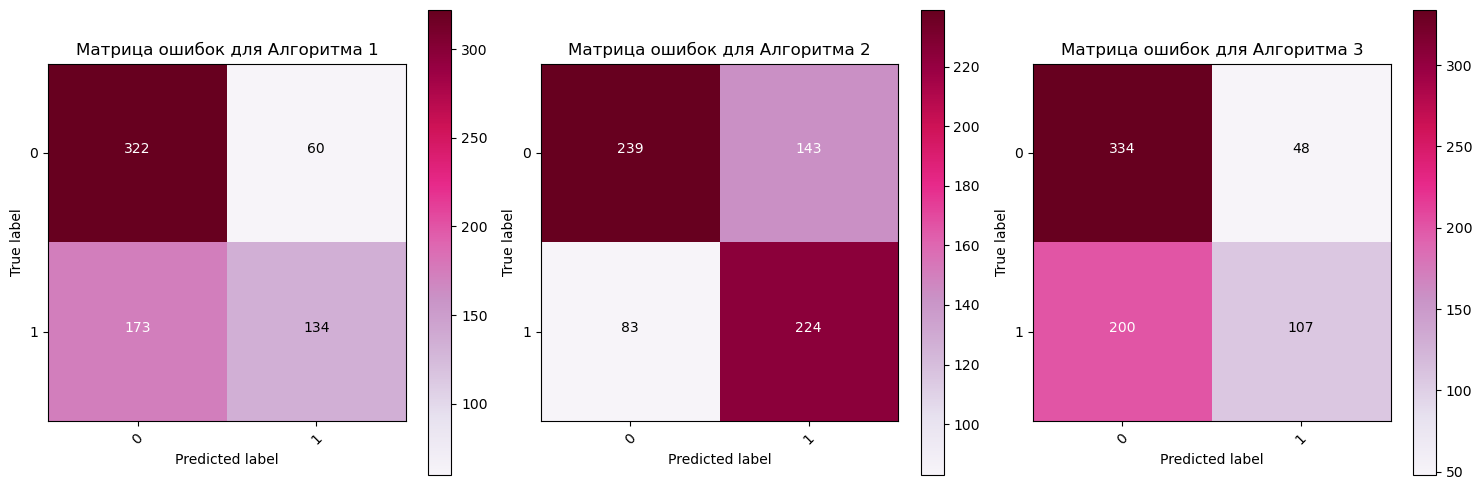

In [39]:
classes = [0, 1]

#матрицы ошбиок для каждого алгоритма
cm1 = confusion_matrix(y_true, df['pred1_classes'])
cm2 = confusion_matrix(y_true, df['pred2_classes'])
cm3 = confusion_matrix(y_true, df['pred3_classes'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes,
                      title='Матрица ошибок для Алгоритма 1')

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes,
                      title='Матрица ошибок для Алгоритма 2')

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes,
                      title='Матрица ошибок для Алгоритма 3')

plt.tight_layout()
plt.show()

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5. (1  балл)** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [40]:
thresholds = np.arange(0, 1, 0.01)
results = {}

for i in range(1, 4): 
    pred_probs = df[f'pred{i}_probs']
    true_labels = df['target']
    best_threshold = 0
    best_recall = 0
    
    for threshold in thresholds:
        predicted_classes = (pred_probs >= threshold).astype(int)
        accuracy = accuracy_score(true_labels, predicted_classes)
        recall = recall_score(true_labels, predicted_classes)
        
        if accuracy >= 0.65 and recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    
    results[f"Алгоритм {i}"] = (best_threshold, best_recall)

print("Алгоритм 1: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*results["Алгоритм 1"]))
print("Алгоритм 2: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*results["Алгоритм 2"]))
print("Алгоритм 3: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*results["Алгоритм 3"]))

Алгоритм 1: Оптимальный порог = 0.36, Максимальная полнота = 0.7427
Алгоритм 2: Оптимальный порог = 0.27, Максимальная полнота = 0.8371
Алгоритм 3: Оптимальный порог = 0.00, Максимальная полнота = 0.0000


**Задание 6. (0.25  баллов)** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

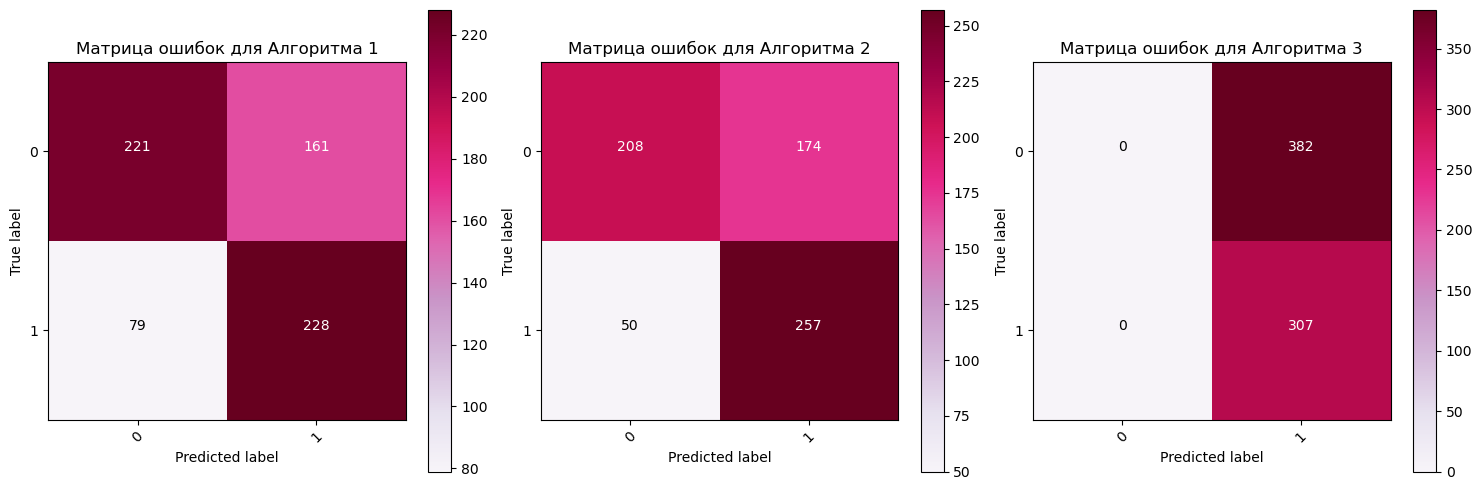

In [41]:
y_true = df['target']

# Применяем порог для предсказания классов
df['pred1_classes'] = (df['pred1_probs'] >= 0.36).astype(int)
df['pred2_classes'] = (df['pred2_probs'] >= 0.27).astype(int)
df['pred3_classes'] = (df['pred3_probs'] >= 0.00).astype(int)

# Создаем матрицы ошибок для каждого алгоритма
cm1 = confusion_matrix(y_true, df['pred1_classes'])
cm2 = confusion_matrix(y_true, df['pred2_classes'])
cm3 = confusion_matrix(y_true, df['pred3_classes'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes=[0, 1], title='Матрица ошибок для Алгоритма 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='Матрица ошибок для Алгоритма 2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='Матрица ошибок для Алгоритма 3')

plt.tight_layout()
plt.show()

**Выводы:** Алгоритм 2 лучше всего справляется с задачей, так как он максимально эффективно классифицирует людей, которые могут вернуть кредит, не теряя при этом слишком много точных случаев.

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7. (0.75  баллов)** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [42]:
precision_results = {}

def find_optimal_thresholds(df, algorithm_index):
    thresholds = np.arange(0.0, 1.0, 0.01) 
    best_precision = 0
    best_threshold = 0
    
    for threshold in thresholds:
        pred_classes = (df[f'pred{algorithm_index}_probs'] >= threshold).astype(int)
        
        accuracy = (pred_classes == df['target']).mean()
        tp = np.sum((pred_classes == 1) & (df['target'] == 1)) 
        fp = np.sum((pred_classes == 1) & (df['target'] == 0))  
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        if accuracy >= 0.65 and precision > best_precision:
            best_precision = precision
            best_threshold = threshold
            
    return best_threshold, best_precision

for i in range(1, 4):  
    optimal_threshold, max_precision = find_optimal_thresholds(df, i)
    precision_results[f'Алгоритм {i}'] = (optimal_threshold, max_precision)

print("Алгоритм 1: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*precision_results["Алгоритм 1"]))
print("Алгоритм 2: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*precision_results["Алгоритм 2"]))
print("Алгоритм 3: Оптимальный порог = {:.2f}, Максимальная полнота = {:.4f}".format(*precision_results["Алгоритм 3"]))

Алгоритм 1: Оптимальный порог = 0.54, Максимальная полнота = 0.7372
Алгоритм 2: Оптимальный порог = 0.73, Максимальная полнота = 0.8367
Алгоритм 3: Оптимальный порог = 0.00, Максимальная полнота = 0.0000


**Задание 8. (0.5  баллов)** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

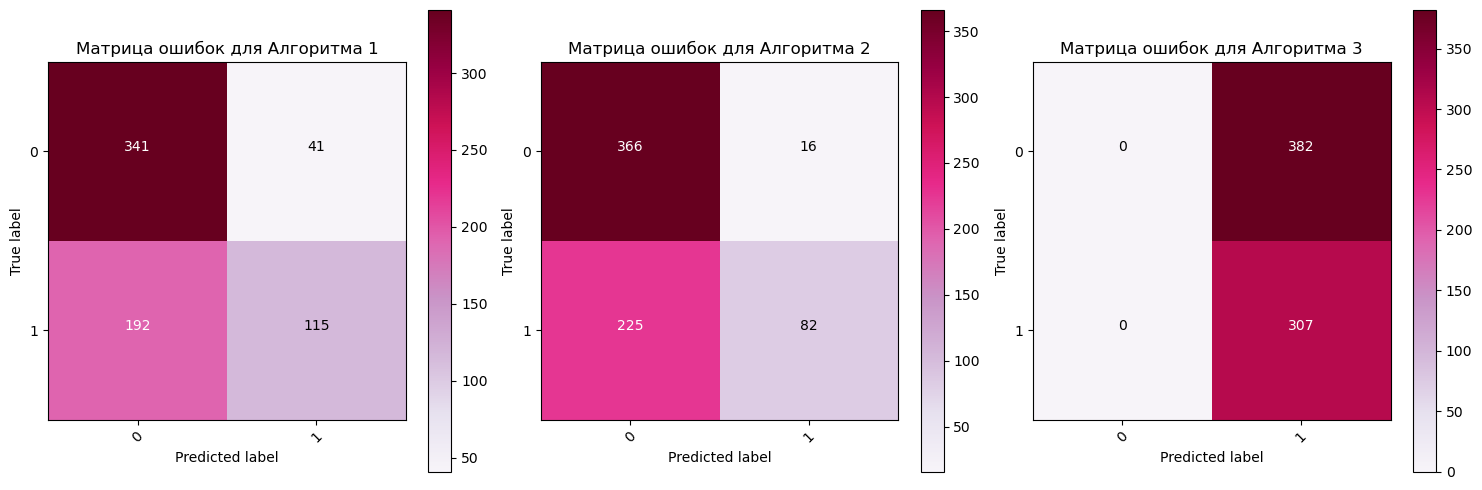

In [23]:
cm1 = confusion_matrix(df['target'], (df['pred1_probs'] >= 0.54).astype(int))
cm2 = confusion_matrix(df['target'], (df['pred2_probs'] >= 0.73).astype(int))
cm3 = confusion_matrix(df['target'], (df['pred3_probs'] >= 0.00).astype(int))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes=[0, 1], title='Матрица ошибок для Алгоритма 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='Матрица ошибок для Алгоритма 2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='Матрица ошибок для Алгоритма 3')

plt.tight_layout()
plt.show()

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9. (0.5  баллов)** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

Алгоритм 1: Оптимальный порог = 0.36, Максимальный F1-Score = 0.66
Алгоритм 2: Оптимальный порог = 0.32, Максимальный F1-Score = 0.70
Алгоритм 3: Оптимальный порог = 0.00, Максимальный F1-Score = 0.00


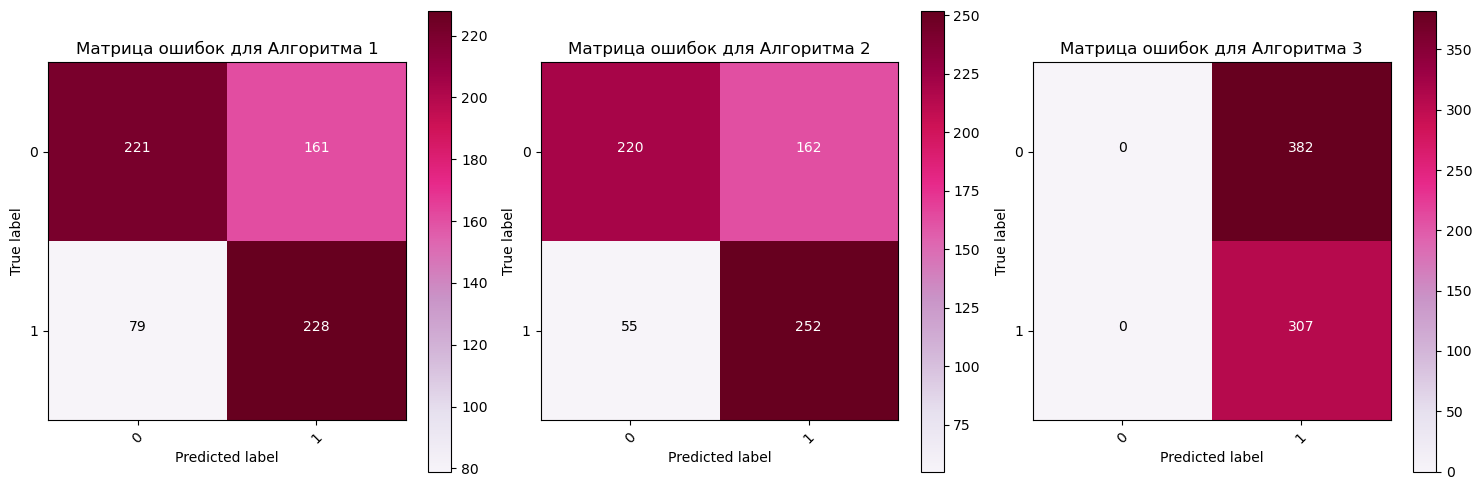

In [43]:
def find_optimal_threshold_for_f1(df, algorithm_index):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_f1 = 0
    best_threshold = 0
    
    for threshold in thresholds:
        pred_classes = (df[f'pred{algorithm_index}_probs'] >= threshold).astype(int)
        
        accuracy = (pred_classes == df['target']).mean()
        precision = precision_score(df['target'], pred_classes)
        recall = recall_score(df['target'], pred_classes)
        f1 = f1_score(df['target'], pred_classes)
        
        if accuracy >= 0.65 and f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold, best_f1

f1_results = {}
for i in range(1, 4):  
    optimal_threshold, max_f1 = find_optimal_threshold_for_f1(df, i)
    f1_results[f'Алгоритм {i}'] = (optimal_threshold, max_f1)


for algorithm, (threshold, f1) in f1_results.items():
    print(f'{algorithm}: Оптимальный порог = {threshold:.2f}, Максимальный F1-Score = {f1:.2f}')

cm1 = confusion_matrix(df['target'], (df['pred1_probs'] >= f1_results['Алгоритм 1'][0]).astype(int))
cm2 = confusion_matrix(df['target'], (df['pred2_probs'] >= f1_results['Алгоритм 2'][0]).astype(int))
cm3 = confusion_matrix(df['target'], (df['pred3_probs'] >= f1_results['Алгоритм 3'][0]).astype(int))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)

plot_confusion_matrix(cm1, classes=[0, 1], title='Матрица ошибок для Алгоритма 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='Матрица ошибок для Алгоритма 2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='Матрица ошибок для Алгоритма 3')

plt.tight_layout()
plt.show()

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [44]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       382
           1       0.59      0.74      0.66       307

    accuracy                           0.65       689
   macro avg       0.66      0.66      0.65       689
weighted avg       0.67      0.65      0.65       689



надеюсъ норм, что я итак ей пользовалась ;)

### Обучим свою модель для предсказания target.

**Задание 10. (0.5  баллов)** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [45]:
X = df.iloc[:, :-4] 
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)


model = LogisticRegression(random_state=16)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        59

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



**Задание 11. (0.5  баллов)** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=16)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_probs = log_reg.predict_proba(X_test)[:, 1]

def find_optimal_threshold(y_true, y_probs, metric):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_metric_value = 0
    best_threshold = 0
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        
        if metric == 'precision':
            metric_value = precision_score(y_true, y_pred)
        elif metric == 'recall':
            metric_value = recall_score(y_true, y_pred)
        elif metric == 'f1':
            metric_value = f1_score(y_true, y_pred)
        else:
            raise ValueError("Unknown metric")
        
        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold
            
    return best_threshold

metrics = ['precision', 'recall', 'f1']
thresholds = {}

for metric in metrics:
    optimal_threshold = find_optimal_threshold(y_test, y_probs, metric)
    thresholds[metric] = optimal_threshold
print(thresholds)

{'precision': 0.9, 'recall': 0.0, 'f1': 0.39}


### Вывод
Оптимальные пороги для recall и f1 отличаются от порогов, найденных в предложенных вариантах. Алгоритмы из вариантов 1 и 2 показали лучшие значения recall с более низкими порогами, в то время как ваш результат для f1 близок к порогам в варианте 3.

В целом, логистическая регрессия показала хорошие результаты, но готовые модели лучше настроены для ситуаций, где нужно сбалансировать несколько метрик.